# Test place for everything

# import functions

In [1]:
from sqlays import export_sql, import_sql
from matheq import Cel_to_Kel, Kel_to_Cel, to_pot_temp
from mapscre import station_map, bathy_data, contour_ver, TS_diagram
from iscays import sum_up, isc_summary, depth_bin_interval, particle_bin_interval, isc_xlsx 
from ctdays import find_start_row, raw_ctd_to_df
from graphcre import deployment_constancy, vertical_each_org_distribution, stacked_vertical_distribution, comp_vertical_distribution
from matheq import calDist
from matplotlib import pyplot as plt
from matplotlib import gridspec
import pandas as pd
import os, glob, datetime

# extract data and image from LOKI_browser by certain interval (distance)

In [ ]:
proj_dir = ('/isibhv/projects/loki/data for Zoomie/PS107_20-5') # dir of folder extracted from loki_browser
meta_file =  glob.glob(os.path.join(proj_dir,'*.csv')) # glob meta data to get the info
meta_df = pd.read_csv(meta_file[0])
meta_df.columns = meta_df.columns.str.strip() # remove empty space of both side of coumns name
print(list(meta_df))
image_datetime = meta_df['Image'].apply(lambda x: x.split(' ')[0]+' '+x.split(' ')[1]).drop_duplicates() # get unique datetime as list

In [14]:
zoomie_csv_dir = os.path.expanduser('~/Git/OCEANpy/data/loki/zoomie_csv')
zoomie_df = pd.DataFrame()
for csv in glob.glob(os.path.join(zoomie_csv_dir, '*.csv')):
    csv_df = pd.read_csv(csv, sep=';|,', header=None, engine='python')
    zoomie_df=zoomie_df.append(csv_df)

zoomie_cols = ['object_length','object_width','object_area_px','object_form','object_area','object_convexity',
              'object_structure','object_graymean','object_kurtosis','object_skewness','object_Hu_moment_1',
              'object_Hu_moment_2','object_Hu_moment_3','object_Hu_moment_4','object_Hu_moment_5','object_Hu_moment_6',
              'object_Hu_moment_7','object_fourier_descriptor_01','object_fourier_descriptor_02',
              'object_fourier_descriptor_03','object_fourier_descriptor_04','object_fourier_descriptor_05',
              'object_fourier_descriptor_06','object_fourier_descriptor_07','object_fourier_descriptor_08',
              'object_fourier_descriptor_09','object_fourier_descriptor_10','img_file_name','object_index',
              'object_cruise','object_station','object_haul','object_date','object_time','object_pressure',
              'object_depth_min','object_salinity','object_conductivity','object_oxygen_concentration',
              'object_temperature_oxsens','object_oxygen_saturation','object_Dr._Haardt_fluorescence_channel_A',
              'object_manual_classification','object_manual_length','object_manual_width','object_posx','object_posy','object_milliseconds',
              'object_timestamp','object_zoomie_state','object_zoomie_deleted','object_zoomie_id','object_zoomie_proc','object_zoomie_group_id']

zoomie_df.columns = zoomie_cols # set column name
zoomie_df = zoomie_df[['object_station','object_zoomie_state', 'object_zoomie_deleted','object_zoomie_group_id', 'img_file_name']]
station = zoomie_df['object_station'].drop_duplicates().to_list()

PS114-04-2


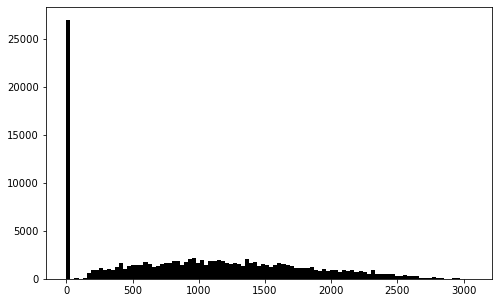

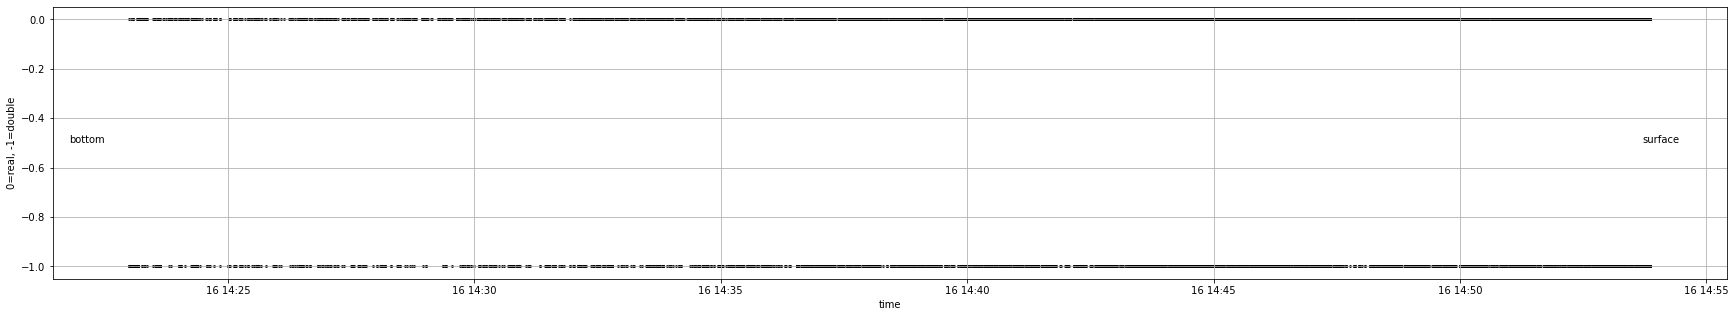

PS94-91-4


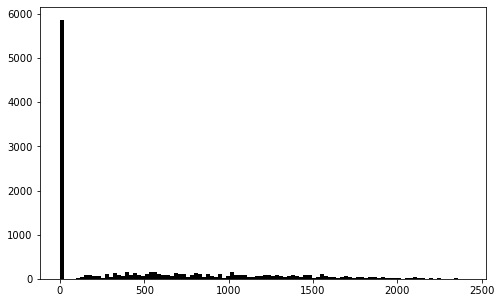

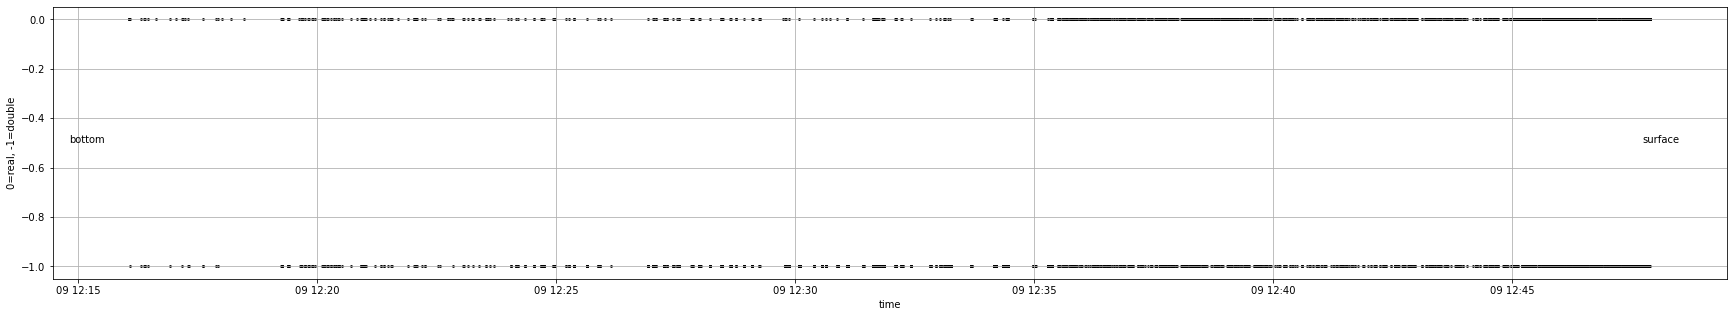

PS122-1_6-86


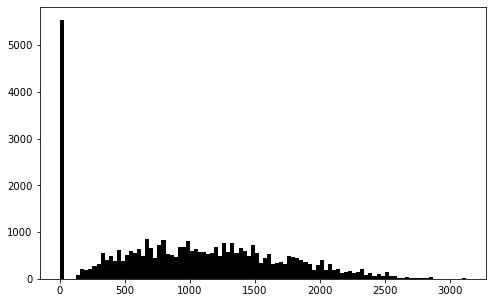

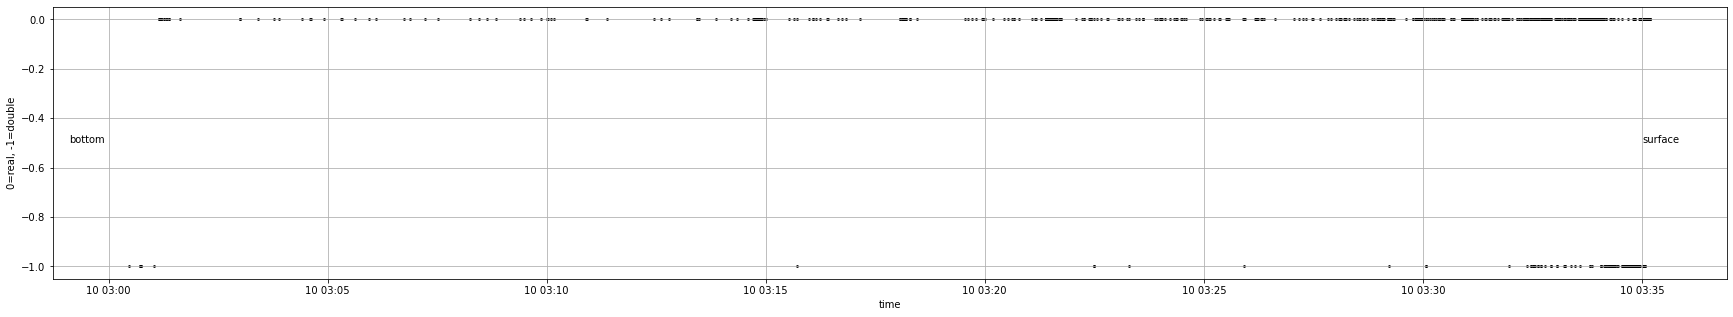

PS106.2-69-6


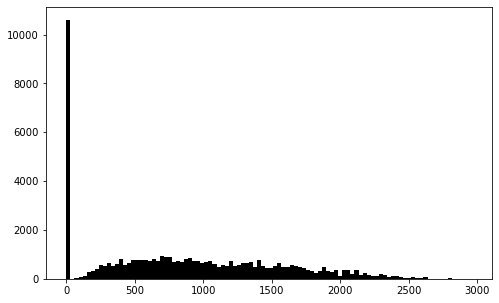

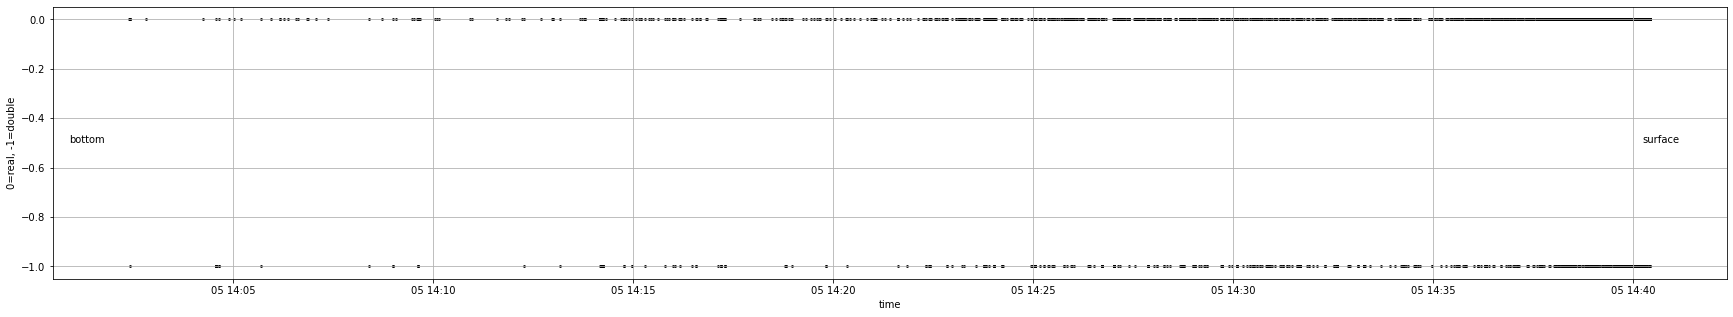

PS107-16


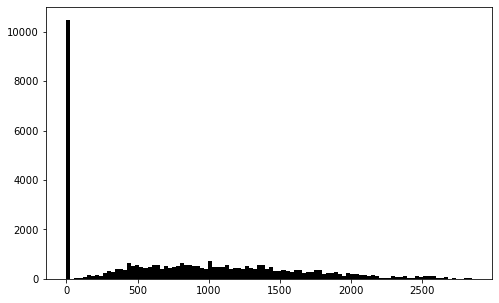

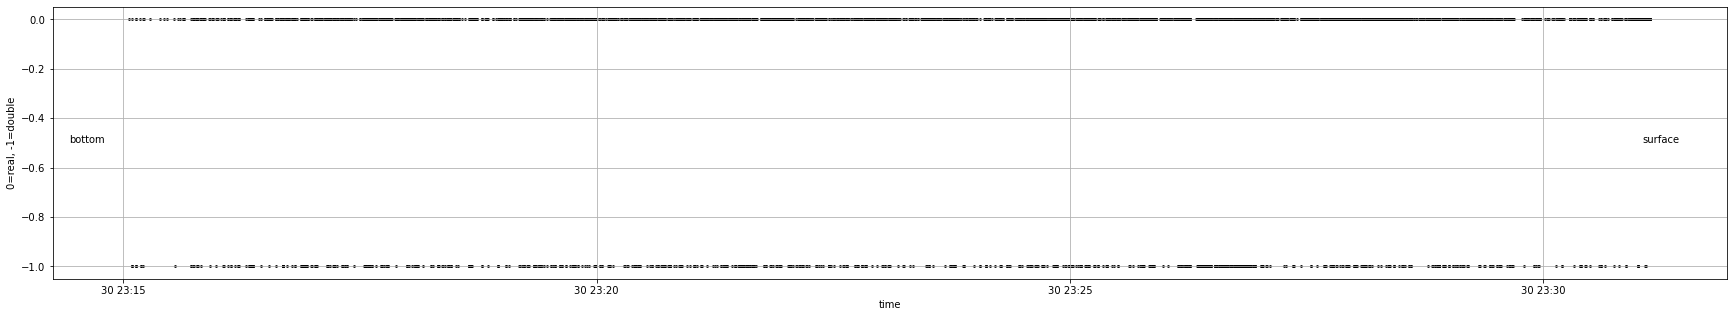

PS94-81-6


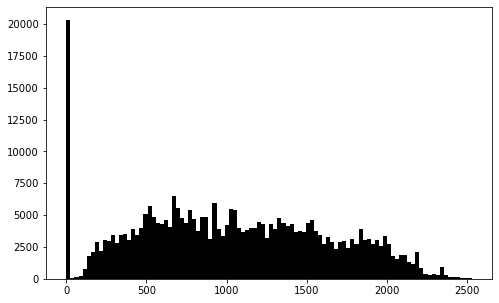

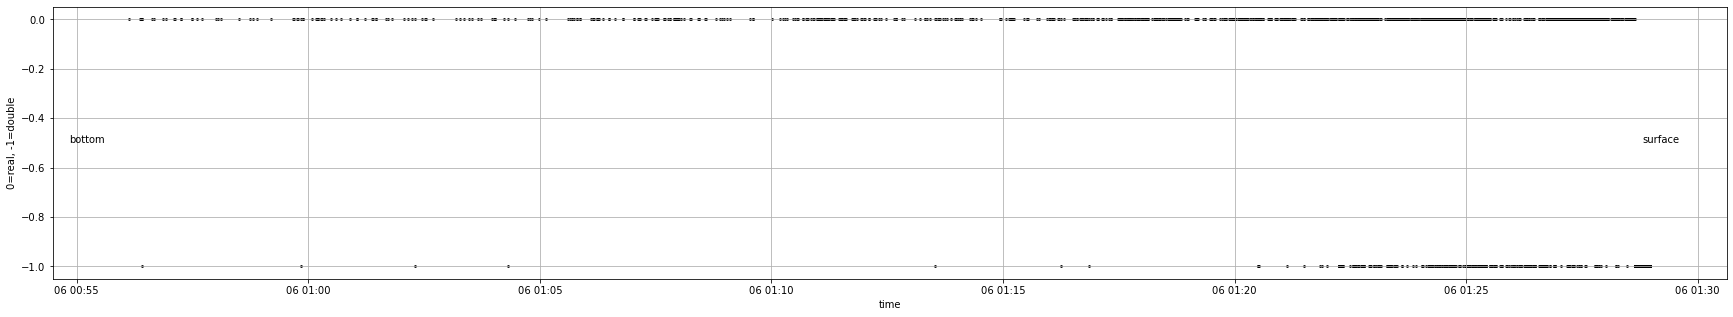

PS106.2-68-4


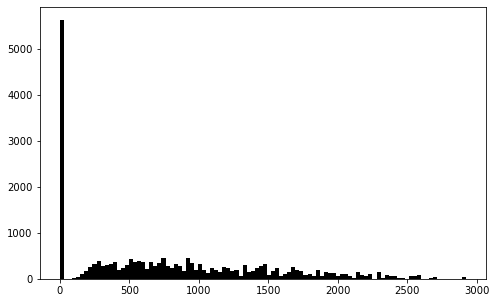

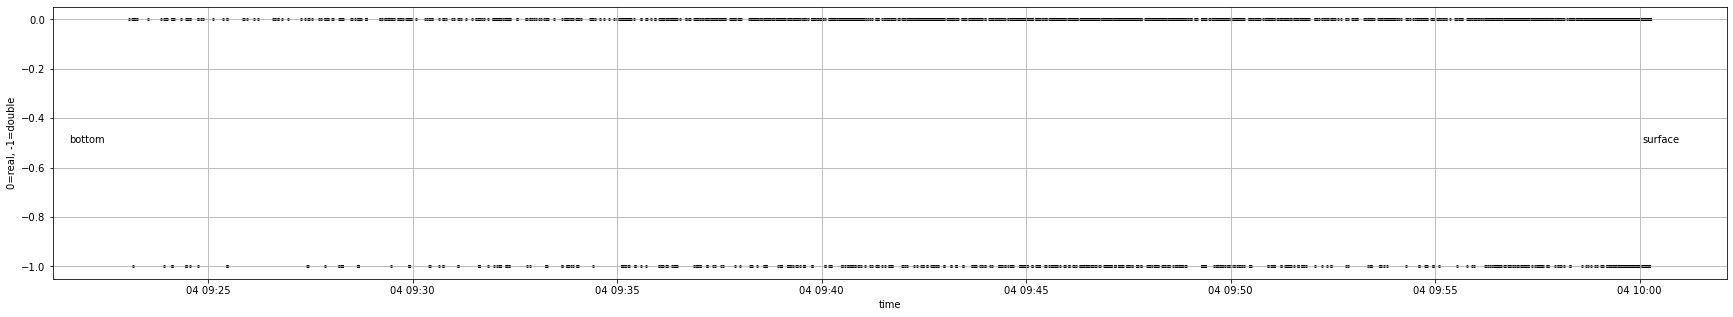

PS122-1-7-57


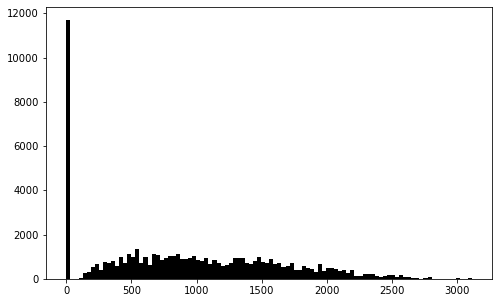

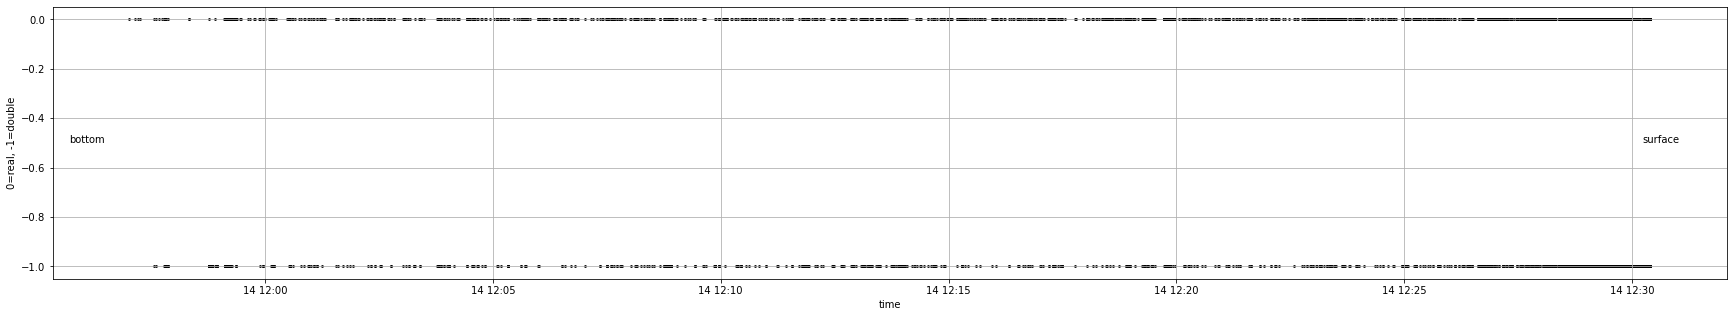

PS107-14


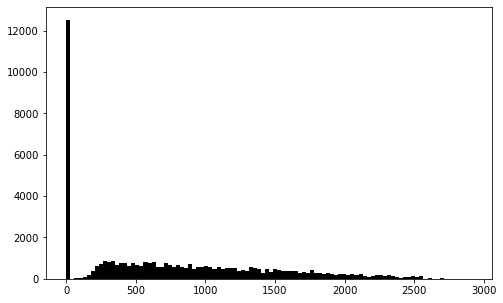

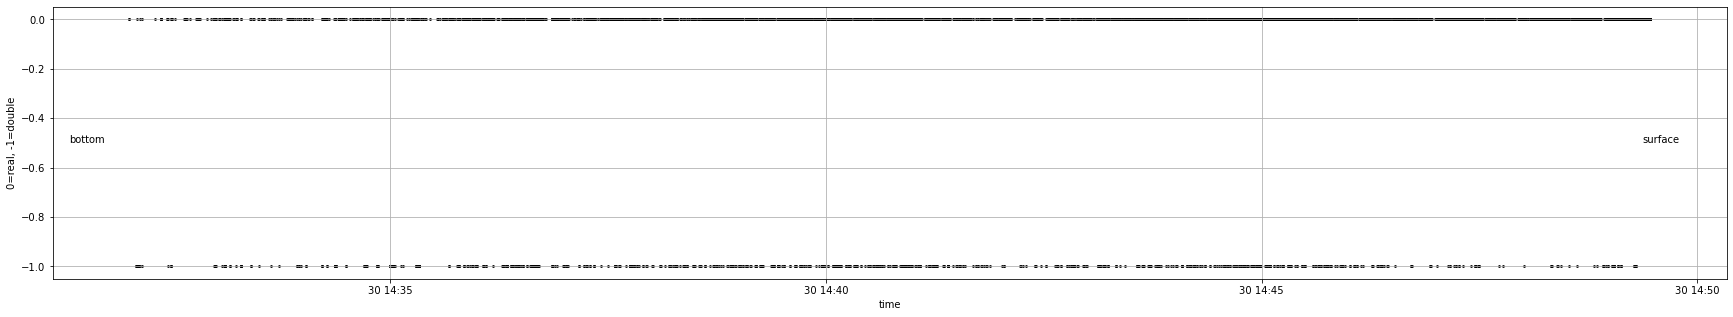

PS94-66-2


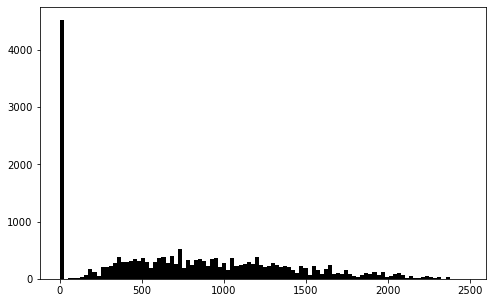

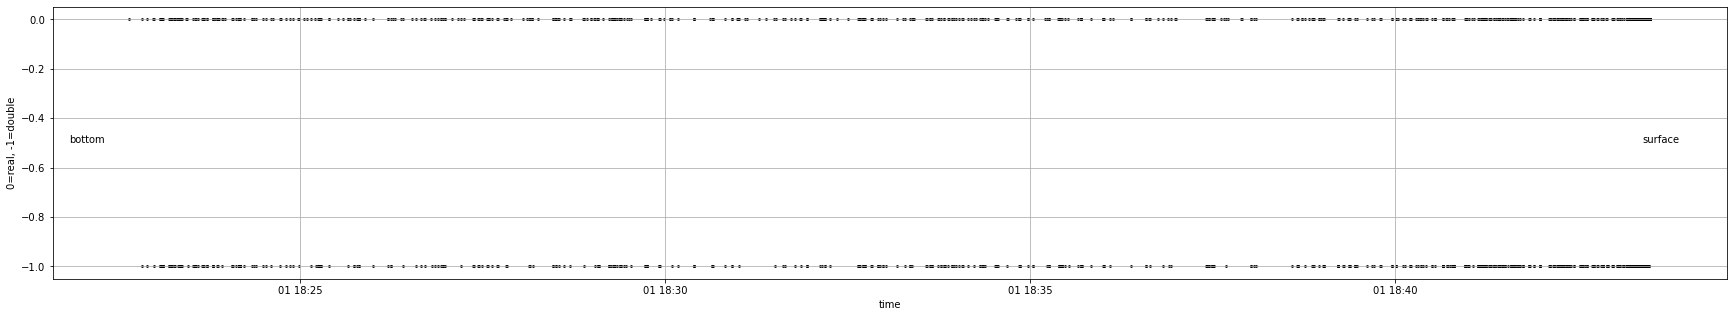

PS122-1-8-73a


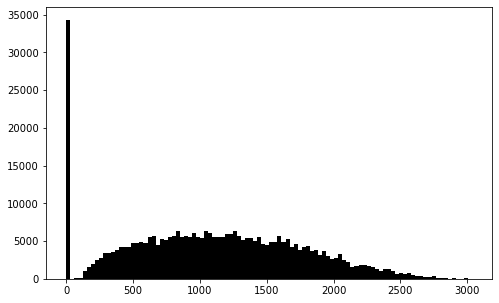

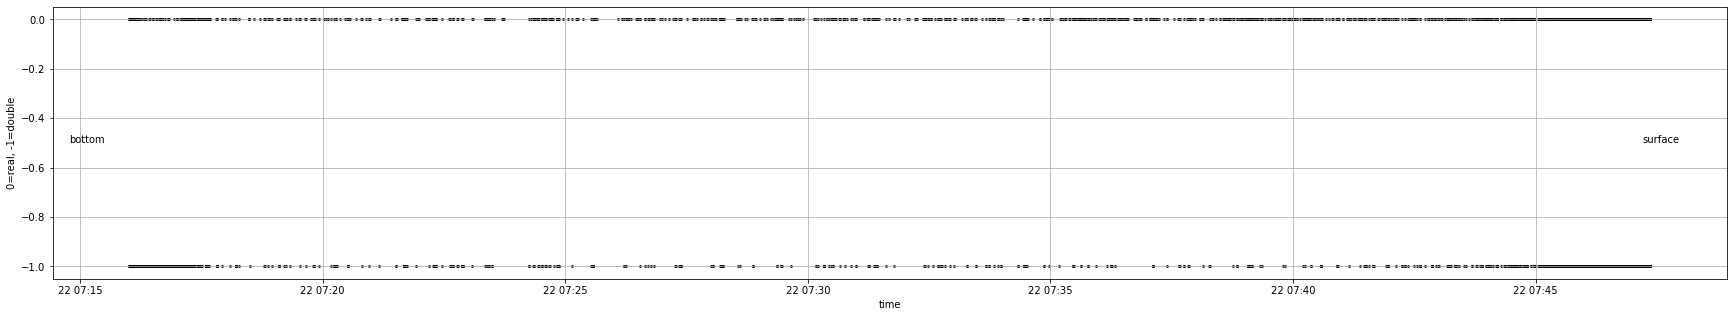

PS106.2-66-1


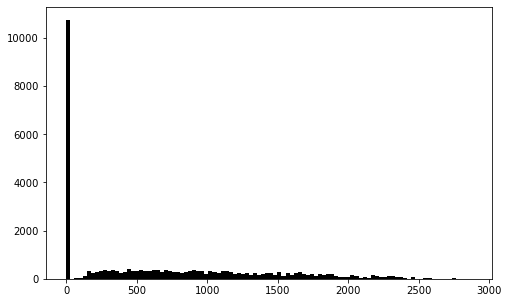

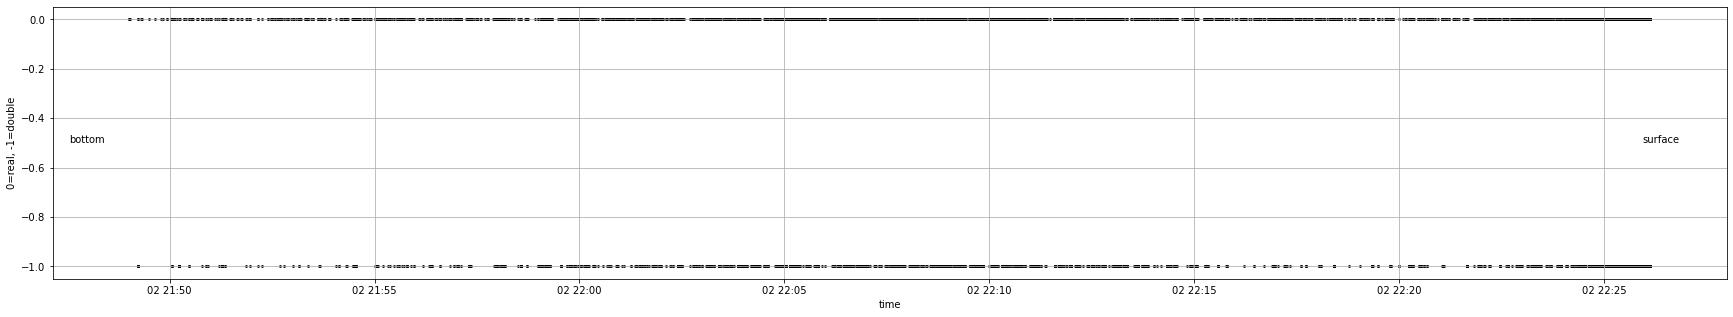

PS93.2-048_9


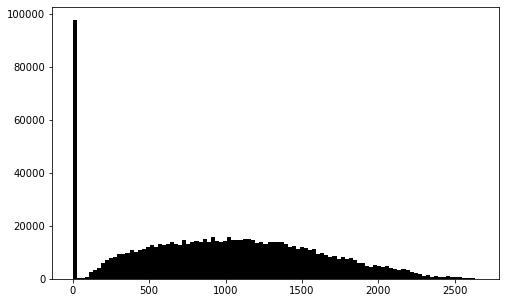

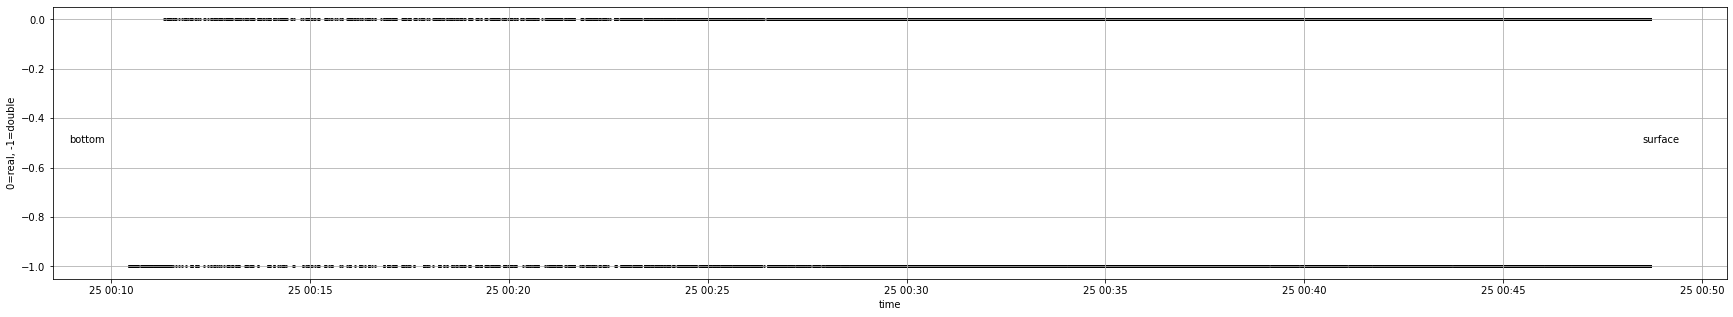

PS99_0053-5


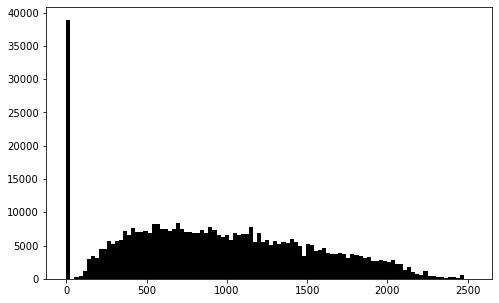

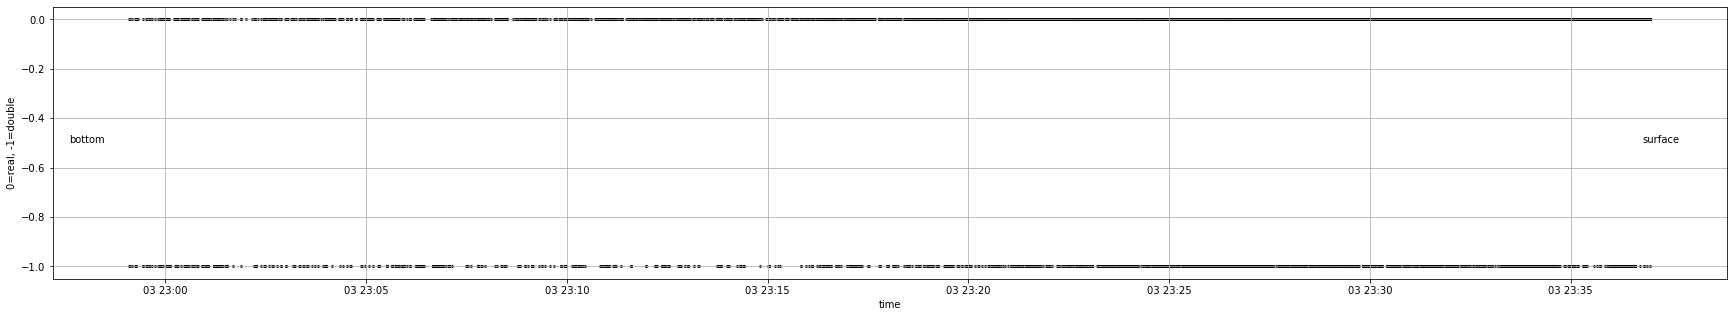

PS106.2-47


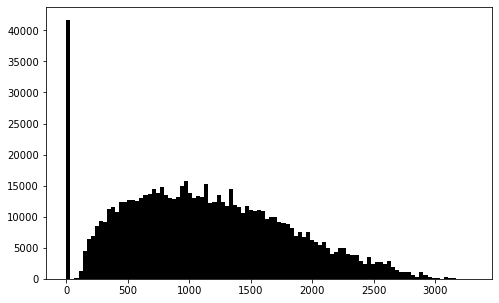

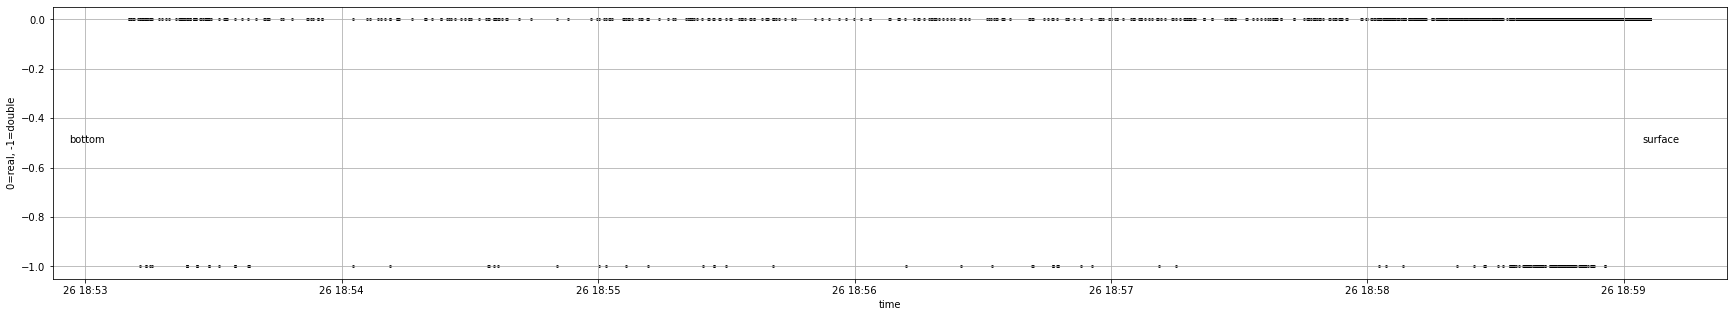

PS106.2-50-3


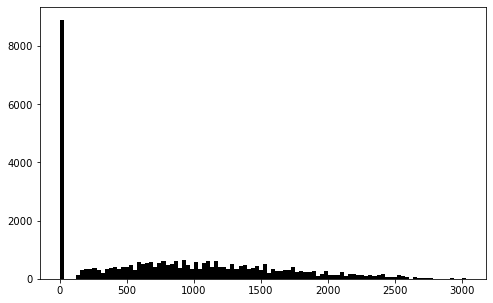

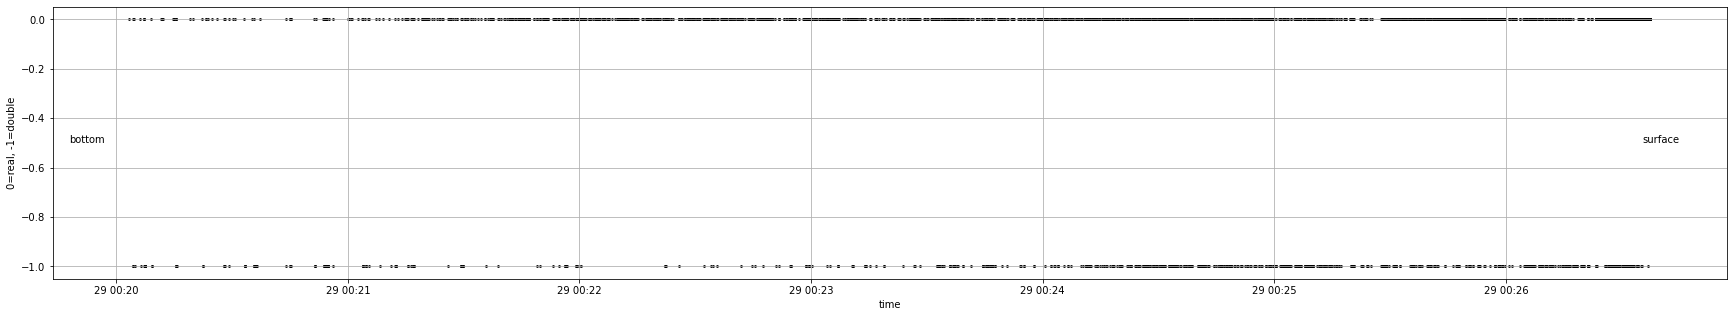

PS107-18


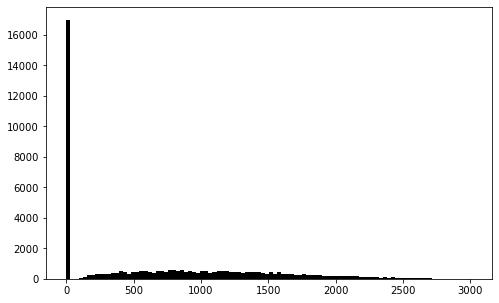

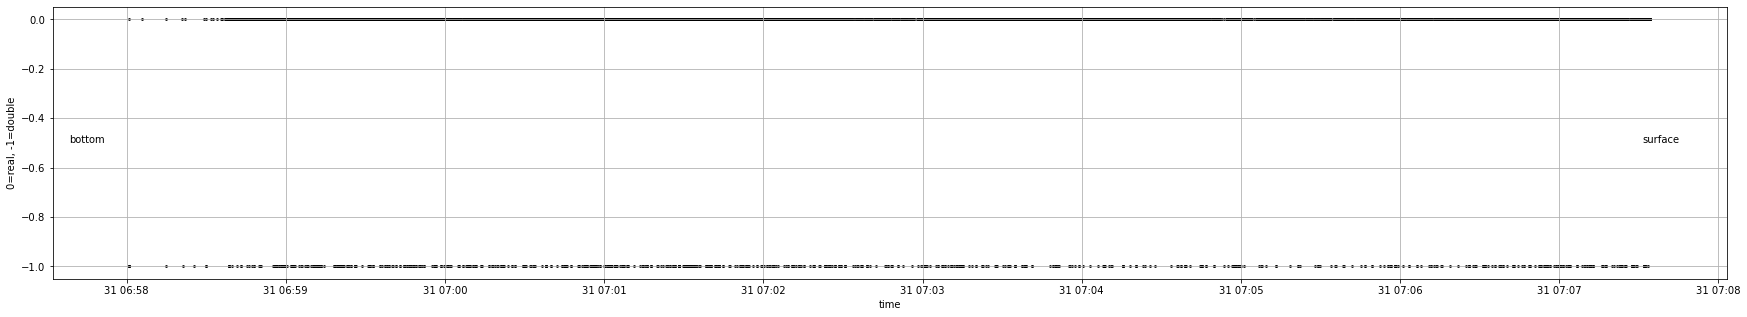

None
PS107-10


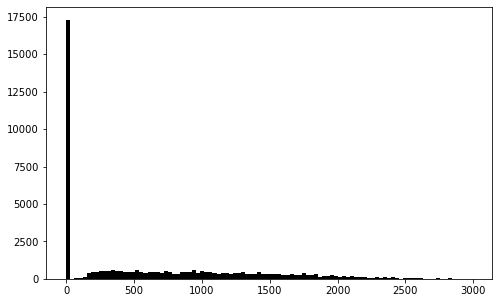

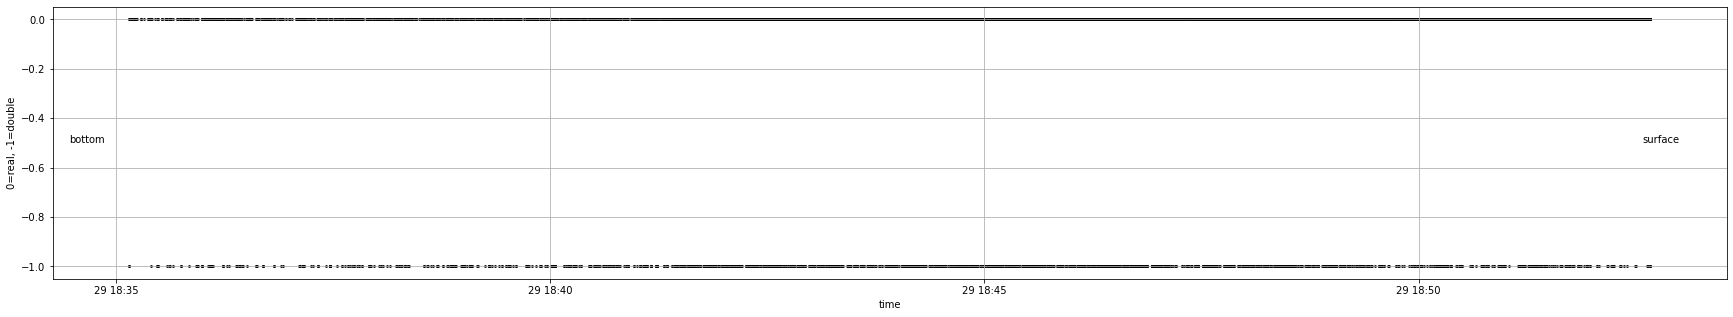

PS94-50-7


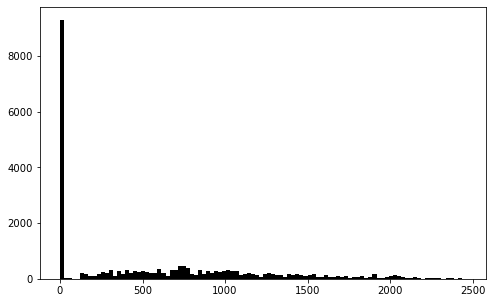

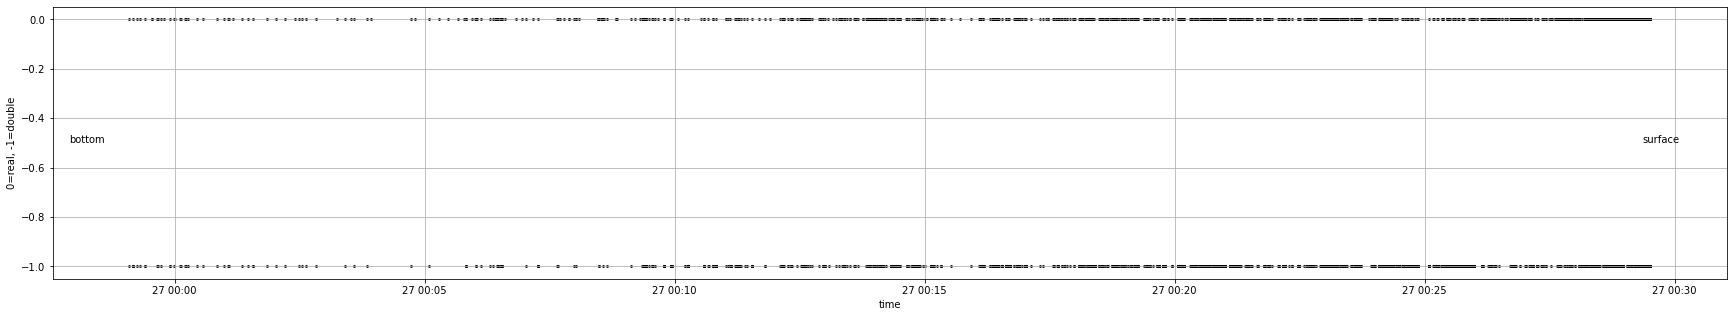

PS122_010


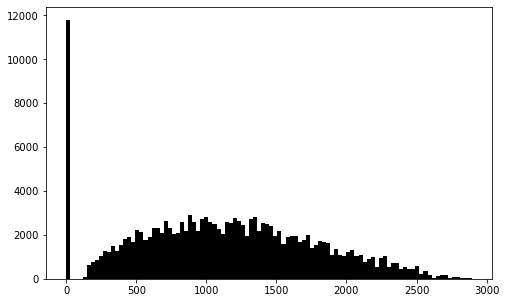

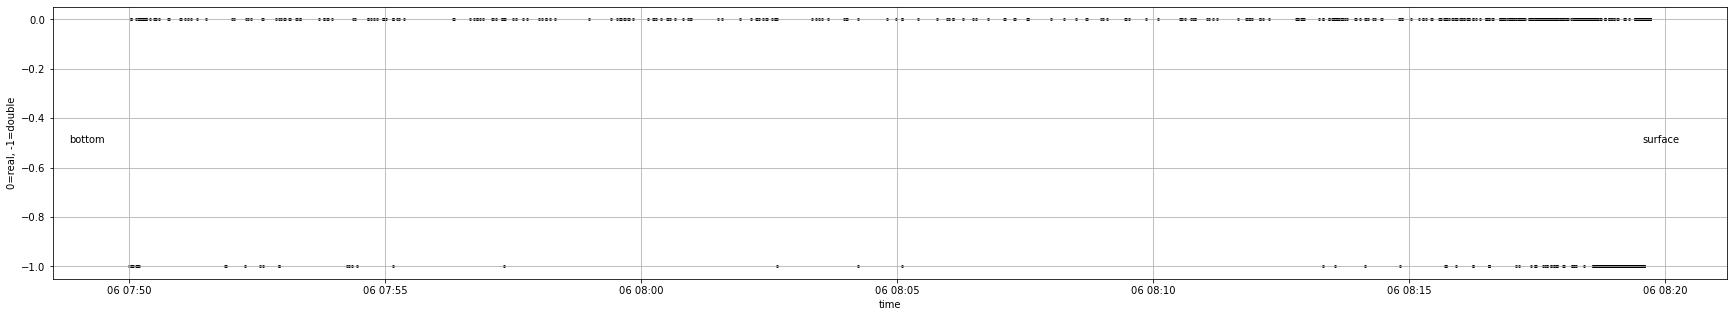

PS122-1-9-62


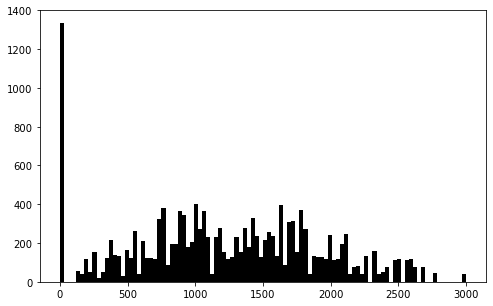

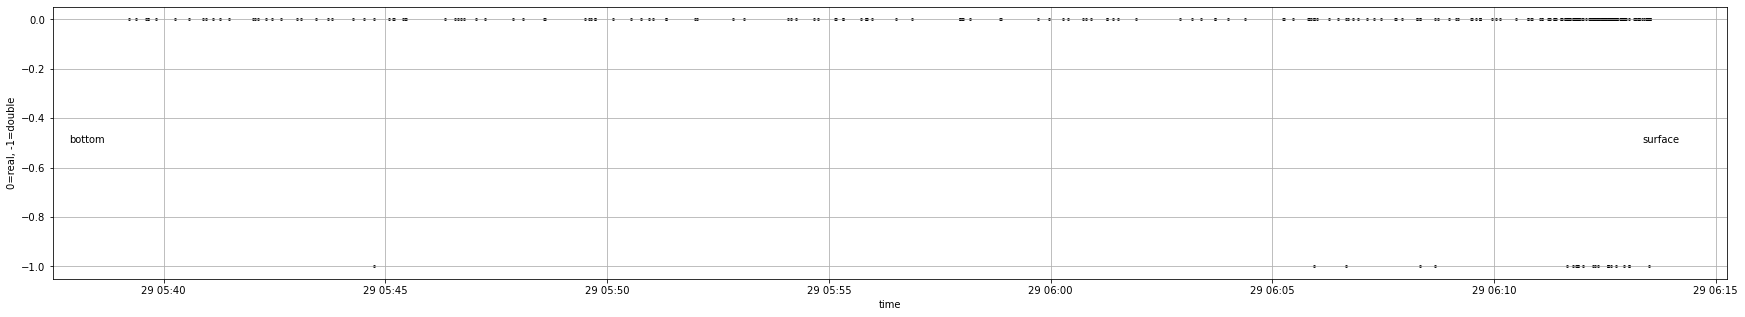

PS107-12


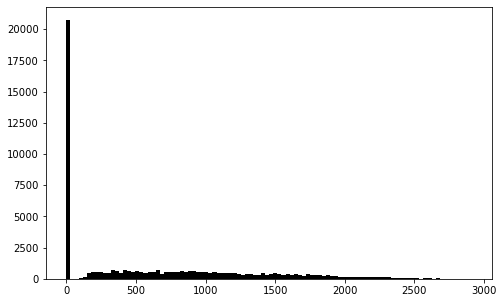

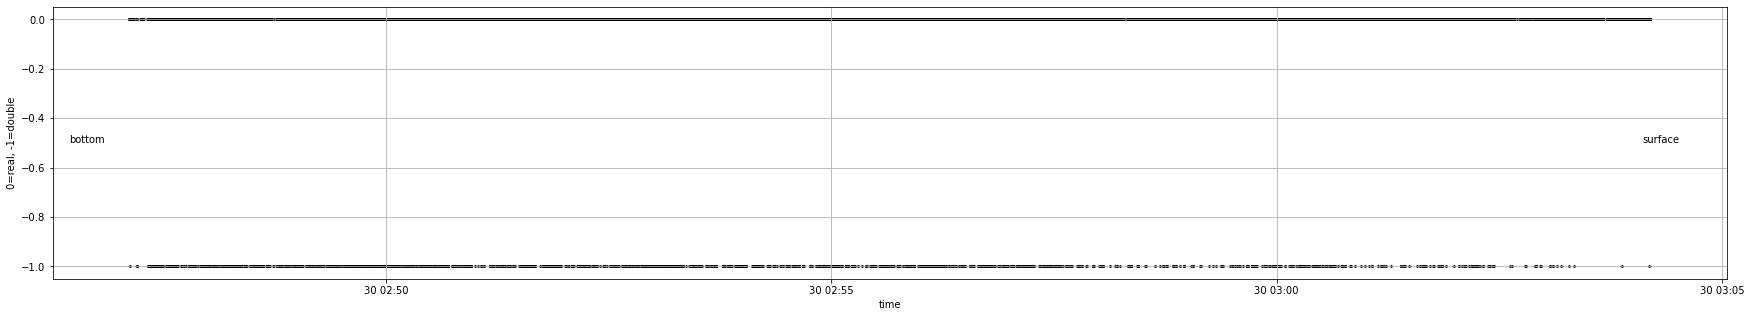

In [16]:
# check time and real, double distribution
for s in station:
    print(s)
    each_zoomie_df = zoomie_df[zoomie_df['object_station']==s]
    if each_zoomie_df.empty == True:
        pass
    else:
        each_zoomie_df = each_zoomie_df.sort_values(by='img_file_name')
        real_mask = ((each_zoomie_df['object_zoomie_state']=='real') & (each_zoomie_df['object_zoomie_deleted']==0))
        time_info = each_zoomie_df['img_file_name'].apply(lambda x: x.split(' ')[0] + ' ' + x.split(' ')[1] + '  ' + x.split(' ')[3]).to_list()
        
        # datetime format
        x_range = [] 
        for i in time_info:
            x_range.append(datetime.datetime.strptime(i, '%Y%m%d %H%M%S  %f'))
        real_mask = [0 if x == True else -1 for x in real_mask]
        
        
        ####
        # testing
        each_zoomie_df['x'] = pd.to_numeric(each_zoomie_df['img_file_name'].apply(lambda x: int(x.split(' ')[-2])))
        each_zoomie_df['y'] = pd.to_numeric(each_zoomie_df['img_file_name'].apply(lambda x: int(x.split(' ')[-1].split('.')[0])))
        
        real_df = pd.DataFrame()
        double_df = pd.DataFrame()
        dist_list = []
        for t in range(0, len(time_info)-1):
            pic_df_before = each_zoomie_df[each_zoomie_df['img_file_name'].str.contains(time_info[t])]
            pic_df_after = each_zoomie_df[each_zoomie_df['img_file_name'].str.contains(time_info[t+1])]
            for b_row in pic_df_before.itertuples():
                for a_row in pic_df_before.itertuples():
                    dist = calDist(getattr(b_row, 'x'), getattr(b_row, 'y'), getattr(a_row, 'x'), getattr(a_row, 'y'))
                    dist_list.append(dist)
                    
        fig = plt.figure(figsize=(8, 5))
        plt.hist(dist_list, bins=100, color='black')
        
        plt.show()
        plt.close()
        

        # plotting
        fig = plt.figure(figsize=(30, 5))
        plt.scatter(x_range, real_mask, color='black', s=3)
        
        plt.xlabel('time')
        plt.ylabel('0=real, -1=double')
        plt.grid()
        plt.annotate('bottom', xy = (0.01, 0.5), xycoords="axes fraction")
        plt.annotate('surface', xy = (0.95, 0.5), xycoords="axes fraction")
        
        plt.show()
        plt.close()


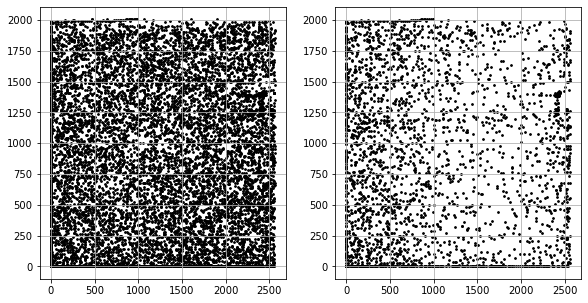

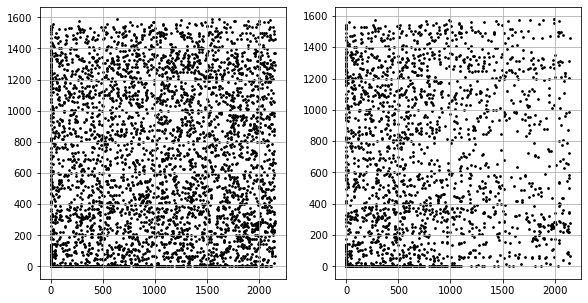

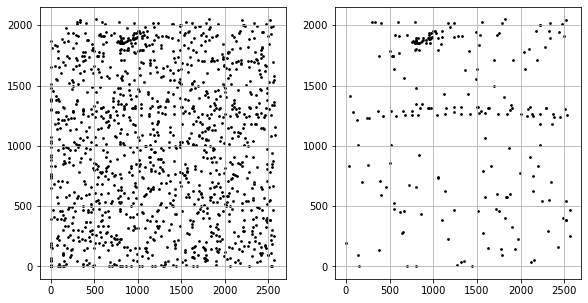

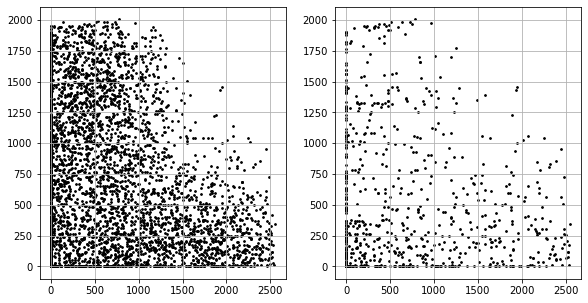

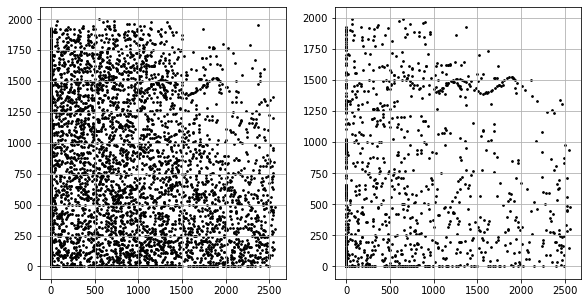

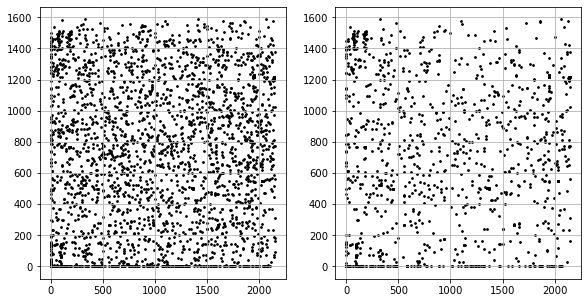

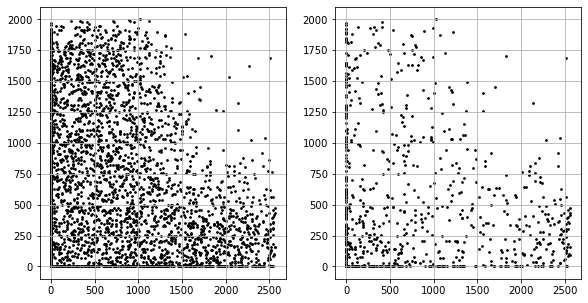

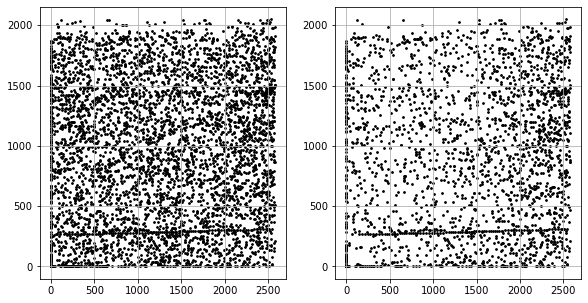

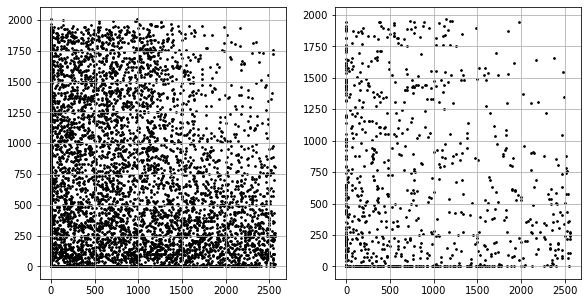

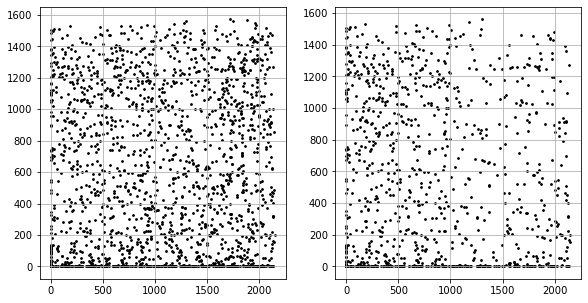

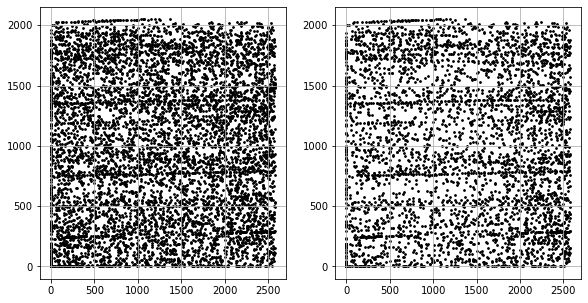

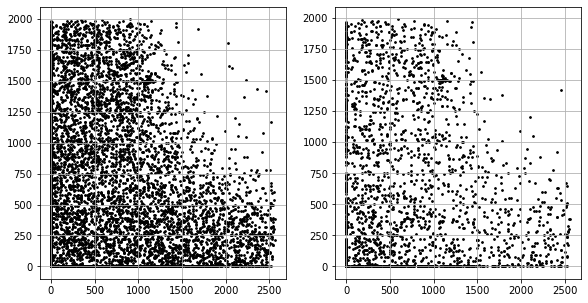

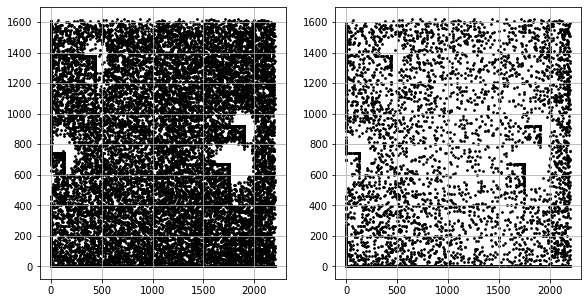

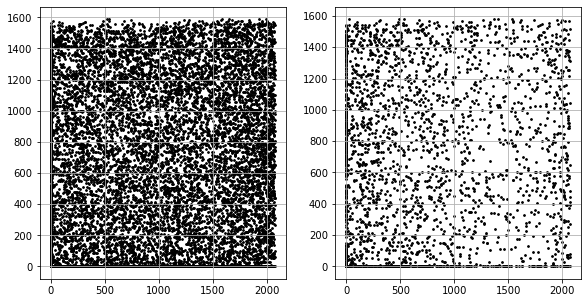

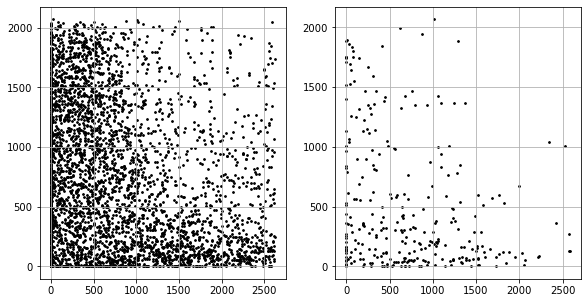

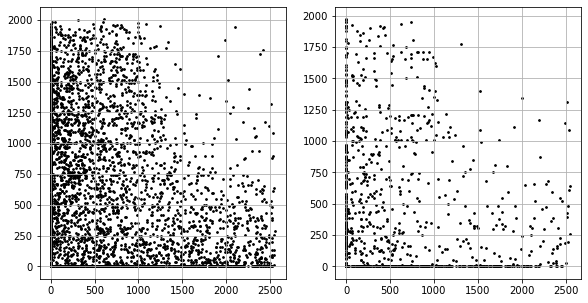

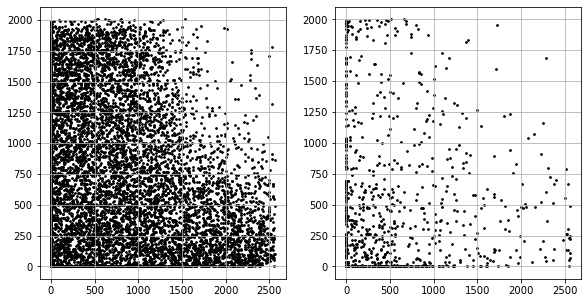

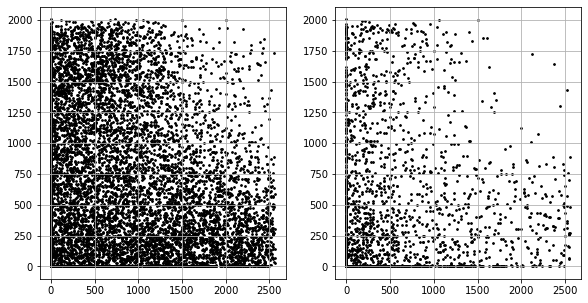

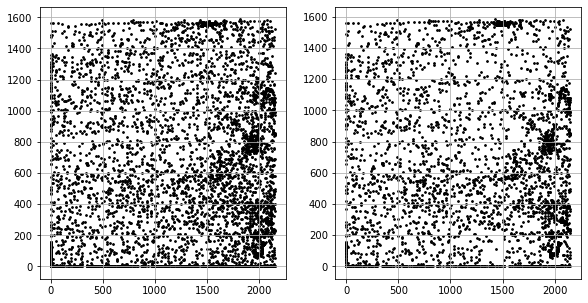

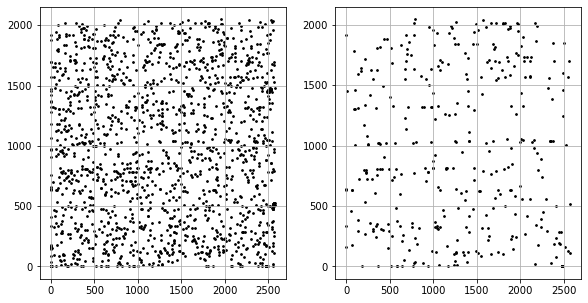

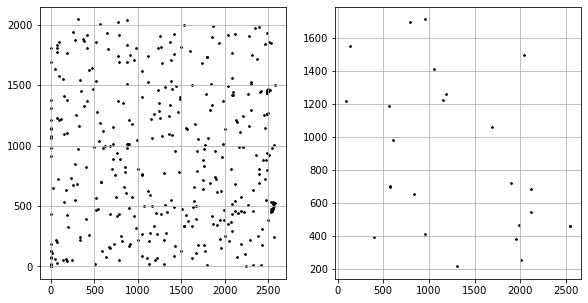

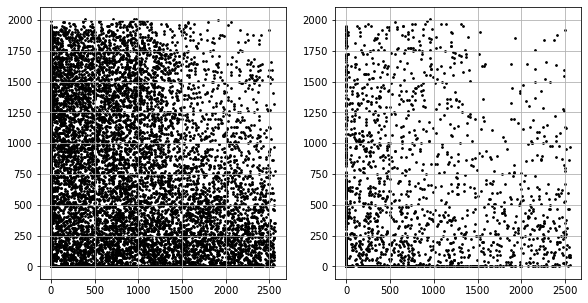

In [168]:
# checking x y coordinate
for s in station:
    each_zoomie_df = zoomie_df[zoomie_df['object_station']==s]
    if each_zoomie_df.empty == True:
        pass
    else:
        # all image
        each_zoomie_df = each_zoomie_df.sort_values(by='img_file_name')
        x_cord_all = each_zoomie_df['img_file_name'].apply(lambda x: int(x.split(' ')[-2])).to_list()
        y_cord_all = each_zoomie_df['img_file_name'].apply(lambda x: int(x.split(' ')[-1].split('.')[0])).to_list()
        
        # double image
        doble_df = each_zoomie_df[(each_zoomie_df['object_zoomie_state']=='double') | (each_zoomie_df['object_zoomie_deleted']==1)]
        x_cord_doble = doble_df['img_file_name'].apply(lambda x: int(x.split(' ')[-2])).to_list()
        y_cord_doble = doble_df['img_file_name'].apply(lambda x: int(x.split(' ')[-1].split('.')[0])).to_list()
        
        
        # plotting
        fig = plt.figure(figsize=(15, 5))
        gs = fig.add_gridspec(1, 3)
        
        ax1 = fig.add_subplot(gs[0,0]) # for all
        ax1.scatter(x_cord_all, y_cord_all, color='black', s=3)
        ax1.grid()
        
        ax2 = fig.add_subplot(gs[0,1]) # for all
        ax2.scatter(x_cord_doble, y_cord_doble, color='black', s=3)
        ax2.grid()
        
        
        plt.show()
        plt.close()


# particle VS zooplankton

In [ ]:
file_path = os.path.expanduser('~/Git/OCEANpy/data')
loki_df = export_sql('loki', ['ps107'], 'awi_server')
ctd_df = export_sql('ctd', 'ctd_meta', 'local')
isc_stb = export_sql('isc', 'isc_meta', 'local')
isc_file_list = glob.glob(file_path+os.sep+'isc'+os.sep+'*.xlsx')
isc_each_df = isc_stb[isc_stb['cruise_station_haul'].str.contains('PS107') & isc_stb['profile_number'].notnull()] # select based on the cruise
print(list(loki_df))
print(loki_df['animal'].drop_duplicates())
print(loki_df['class'].drop_duplicates())
print(loki_df['family'].drop_duplicates())
print(loki_df['genus'].drop_duplicates())


In [ ]:
for index, value in isc_each_df.iterrows():
    # select one station from one isc station and get cruise name, station number and profilenumber of ISC
    cruise, station, profile_num = value['cruise_station_haul'].split('_')[0], int(float(value['cruise_station_haul'].split('_')[1])), int(float(value['profile_number']))
    
    # Based on the cruise and profilenumber of ISC import data from excel file
    isc_excel = str('IR'+str(profile_num).zfill(2)+'_DownCast_'+cruise+'.xlsx')
    for i in isc_file_list:
        if i.split(os.sep)[-1] == isc_excel:
            particle_range = [150, 500, 1000, 100000]
            
            # from here specific station.
            isc_ctd_df, vol_spec_df, aggr_con_df, size_spec_df = isc_xlsx(i, 10, particle_range)
            vol, abd, isc_ctd, ctd_dict = isc_summary(isc_ctd_df, vol_spec_df, aggr_con_df, particle_range)
            loki_station_df = loki_df[loki_df['station'].str.contains(cruise+'_'+str(station).zfill(3)) & loki_df['animal']==True] # select corresponding loki station
            if loki_station_df.empty:
                continue
            else:
                ctd_station_df = ctd_df[ctd_df['Event'].str.contains(cruise+'_'+str(station))] # select corresponding ctd station
                
                copepoda_df = loki_station_df[loki_station_df['copepod']==True] # df only for copepoda
                copepoda_depth = copepoda_df['loki_depth'].to_list()
                
                oncaeidae_df = loki_station_df[loki_station_df['family']=='Oncaeidae'] # df only for copepoda
                oncaeidae_depth = oncaeidae_df['loki_depth'].to_list()
                
                calanidae_df = loki_station_df[loki_station_df['family']=='Calanidae'] # df only for copepoda
                calanidae_depth = calanidae_df['loki_depth'].to_list()
                
                metridinidae_df = loki_station_df[loki_station_df['family']=='Metridinidae'] # df only for copepoda
                metridinidae_depth = metridinidae_df['loki_depth'].to_list()
                
                loki_family_dict = dict(loki_station_df['family'].value_counts())
                
                
                fig = plt.figure(constrained_layout=True, figsize =(10, 25))
                gs = fig.add_gridspec(6, 3)
                
                #fig, axs = plt.subplots(6,3, figsize = (10, 25))
                #axs = axs.ravel()

                # 1st plot for temperature and salanity / data from CTD, ISC CTD, LOKI CTD
                ### CTD ###
                ax1 = fig.add_subplot(gs[0,0])
                ax1.plot(tuple(pd.to_numeric(ctd_station_df['Temp [°C]'])), tuple(pd.to_numeric(ctd_station_df['Depth water [m]'])), color='red', linewidth= 1, alpha=0.7)
                ax1.set_ylabel(ctd_dict['depth'], color ='black')
                ax1.set_xlabel(ctd_dict['temp'], color = 'red')
                ax1.set_xlim(-3, 9)
                ax1.set_ylim(0,500)
                ax1.invert_yaxis()
                ax1.annotate('CTD', xy=(0.05, 0.05), xycoords='axes fraction', fontsize=10)

                sec_axs = ax1.twiny()
                sec_axs.plot(tuple(pd.to_numeric(ctd_station_df['Sal'])), tuple(pd.to_numeric(ctd_station_df['Depth water [m]'])), color ='blue', linewidth= 1, alpha=0.7)
                sec_axs.set_xlabel(ctd_dict['sal'], color = 'blue')
                sec_axs.set_xlim(30, 36)
                
                ### ISC CTD ###
                ax2 = fig.add_subplot(gs[0,1])
                ax2.plot(isc_ctd['temp'], isc_ctd['depth'], color='red', linewidth= 1, alpha=0.7)
                ax2.set_ylabel(ctd_dict['depth'], color ='black')
                ax2.set_xlabel(ctd_dict['temp'], color = 'red')
                ax2.set_xlim(-3, 9)
                ax2.set_ylim(0,500)
                ax2.invert_yaxis()
                ax2.annotate('ISC CTD', xy=(0.05, 0.05), xycoords="axes fraction", fontsize=10)

                sec_axs = ax2.twiny()
                sec_axs.plot(isc_ctd['sal'], isc_ctd['depth'], color ='blue', linewidth= 1, alpha=0.7)
                sec_axs.set_xlabel(ctd_dict['sal'], color = 'blue')
                sec_axs.set_xlim(30, 36)
                
                ### LOKI CTD ###
                ax3 = fig.add_subplot(gs[0,2])
                ax3.plot(loki_station_df['temperatue'], loki_station_df['loki_depth'], color='red', linewidth= 1, alpha=0.7)
                ax3.set_ylabel(ctd_dict['depth'], color ='black')
                ax3.set_xlabel(ctd_dict['temp'], color = 'red')
                ax3.set_xlim(-3, 9)
                ax3.set_ylim(0,500)
                ax3.invert_yaxis()
                ax3.annotate('LOKI CTD', xy=(0.05, 0.05), xycoords="axes fraction", fontsize=10)

                sec_axs = ax3.twiny()
                sec_axs.plot(loki_station_df['salinity'], loki_station_df['loki_depth'], color ='blue', linewidth= 1, alpha=0.7)
                sec_axs.set_xlabel(ctd_dict['sal'], color = 'blue')
                sec_axs.set_xlim(30, 36)
                
                # 2nd plot for turbidity and Fluorescence / data from CTD, ISC CTD, LOKI CTD
                ### CTD ###
                ax4 = fig.add_subplot(gs[1,0])
                ax4.plot(tuple(pd.to_numeric(ctd_station_df['Fluorometer [arbitrary units]'])), tuple(pd.to_numeric(ctd_station_df['Depth water [m]'])), color='red', linewidth= 1, alpha=0.7)
                ax4.set_ylabel(ctd_dict['depth'], color ='black')
                ax4.set_xlabel(ctd_dict['fluo'], color = 'red')
                ax4.set_xlim(-0.5, 6)
                ax4.set_ylim(0,500)
                ax4.invert_yaxis()
                ax4.annotate('CTD', xy=(0.05, 0.05), xycoords="axes fraction", fontsize=10)
                
                ### ISC CTD ###
                ax5 = fig.add_subplot(gs[1,1])
                ax5.plot(isc_ctd['fluo'], isc_ctd['depth'], color='red', linewidth= 1, alpha=0.7)
                ax5.set_ylabel(ctd_dict['depth'], color ='black')
                ax5.set_xlabel(ctd_dict['fluo'], color = 'red')
                ax5.set_xlim(-0.5, 6)
                ax5.set_ylim(0,500)
                ax5.invert_yaxis()
                ax5.annotate('ISC CTD', xy=(0.05, 0.05), xycoords="axes fraction", fontsize=10)

                sec_axs = ax5.twiny()
                sec_axs.plot(isc_ctd['turb'], isc_ctd['depth'], color ='blue', linewidth= 1, alpha=0.7)
                sec_axs.set_xlabel(ctd_dict['turb'], color = 'blue')
                sec_axs.set_xlim(-0.5, 6)
                
                ### LOKI CTD ###
                ax6 = fig.add_subplot(gs[1,2])
                ax6.plot(loki_station_df['fluorescence'], loki_station_df['loki_depth'], color='red', linewidth= 1, alpha=0.7)
                ax6.set_ylabel(ctd_dict['depth'], color ='black')
                ax6.set_xlabel(ctd_dict['fluo'], color = 'red')
                ax6.set_xlim(-0.5, 6)
                ax6.set_ylim(0,500)
                ax6.invert_yaxis()
                ax6.annotate('LOKI CTD', xy=(0.05, 0.05), xycoords="axes fraction", fontsize=10)

                
                # 3rd plot for Aggregate Volume
                ax7 = fig.add_subplot(gs[2,0])
                ax7.plot(vol['vol_sml'], isc_ctd['depth'], color='red', linewidth= 1, alpha=0.7)
                ax7.set_xlabel('vol 0.15-0.5 [mm]', color = 'red')
                ax7.set_ylim(0,500)
                ax7.invert_yaxis()

                sec_axs = ax7.twiny()
                sec_axs.plot(vol['vol_med'], isc_ctd['depth'], color ='blue', linewidth= 1, alpha=0.7)
                sec_axs.set_xlabel('vol 0.5-1 [mm]', color = 'blue')
                
                ax8 = fig.add_subplot(gs[2,1])
                ax8.plot(vol['vol_lrg'], isc_ctd['depth'], color='red', linewidth= 1, alpha=0.7)
                ax8.set_xlabel('vol 1 [mm] > ', color = 'red')
                ax8.set_ylim(0,500)
                ax8.invert_yaxis()

                sec_axs = ax8.twiny()
                sec_axs.plot(vol['vol_tol'], isc_ctd['depth'], color ='blue', linewidth= 1, alpha=0.7)
                sec_axs.set_xlabel('vol total (0.15 [mm] > )', color = 'blue')

                # 4th plot for Aggregate abundance
                ax9 = fig.add_subplot(gs[3,0])
                ax9.plot(abd['abd_sml'], isc_ctd['depth'], color='red', linewidth= 1, alpha=0.7)
                ax9.set_xlabel('abd 0.15-0.5 [mm]', color = 'red')
                ax9.set_ylim(0,500)
                ax9.invert_yaxis()

                sec_axs = ax9.twiny()
                sec_axs.plot(abd['abd_med'], isc_ctd['depth'], color ='blue', linewidth= 1, alpha=0.7)
                sec_axs.set_xlabel('abd 0.5-1 [mm]', color = 'blue')
                
                ax10 = fig.add_subplot(gs[3,1])
                ax10.plot(abd['abd_lrg'], isc_ctd['depth'], color='red', linewidth= 1, alpha=0.7)
                ax10.set_xlabel('abd 1 [mm] > ', color = 'red')
                ax10.set_ylim(0,500)
                ax10.invert_yaxis()

                sec_axs = ax10.twiny()
                sec_axs.plot(abd['abd_tol'], isc_ctd['depth'], color ='blue', linewidth= 1, alpha=0.7)
                sec_axs.set_xlabel('abd total (0.15 [mm] > )', color = 'blue')
                
                # 5th plot for zooplankton
                ax11 = fig.add_subplot(gs[4,:2])
                ax11.bar(loki_family_dict.keys(), loki_family_dict.values(), color='black') # family abundance check
                ax11.tick_params(rotation=90)
                
                ax12 = fig.add_subplot(gs[4,-1])
                ax12.hist(copepoda_depth, orientation='horizontal', bins = int(max(copepoda_depth)/10), color ='black')
                ax12.set_ylim(0,500)
                ax12.set_xlim(0,300)
                ax12.set_xlabel('copepoda [count]', color = 'black')
                ax12.invert_yaxis()
                
                ax13 = fig.add_subplot(gs[5,0])
                ax13.hist(oncaeidae_depth, orientation='horizontal', bins = int(max(oncaeidae_depth)/10), color ='black')
                ax13.set_ylim(0,500)
                ax13.set_xlim(0,300)
                ax13.set_xlabel('oncaeidae [count]', color = 'black')
                ax13.invert_yaxis()
                
                ax14 = fig.add_subplot(gs[5,1])
                ax14.hist(calanidae_depth, orientation='horizontal', bins = int(max(calanidae_depth)/10), color ='black')
                ax14.set_ylim(0,500)
                ax14.set_xlim(0,300)
                ax14.set_xlabel('calanidae [count]', color = 'black')
                ax14.invert_yaxis()
                
                ax15 = fig.add_subplot(gs[5,2])
                ax15.hist(metridinidae_depth, orientation='horizontal', bins = int(max(metridinidae_depth)/10), color ='black')
                ax15.set_ylim(0,500)
                ax15.set_xlim(0,300)
                ax15.set_xlabel('metridinidae [count]', color = 'black')
                ax15.invert_yaxis()
                
                # addtional plot modification
                #fig.tight_layout(pad=3, h_pad=1, w_pad=1) # adjust layout of subplots
                #plt.suptitle(title, y = 0.99) # main title
                
                os.chdir(os.path.expanduser('~/Git/OCEANpy/plots'))
                fig_name = str('isc_loki_comp_'+cruise+'_'+str(station)+'.png')
                plt.savefig(fig_name, facecolor='w')
                plt.close()

# create TS diagram

In [ ]:
ctd_df = export_sql('ctd', 'ctd_meta')
#station_list = ['PS107_18']
#ctd_df = ctd_df.loc[ctd_df['Event'].str.contains('|'.join(station_list))]
ctd_df = ctd_df.loc[pd.to_numeric(ctd_df['Depth water [m]']) <=1000]
depth = tuple(pd.to_numeric(ctd_df['Depth water [m]']))
sal = tuple(pd.to_numeric(ctd_df['Sal']))
temp = tuple(pd.to_numeric(ctd_df['Temp [°C]']))
TSD_dict = {'temp': temp, 'sal': sal, 'depth':depth}
TS_diagram(TSD_dict)


# create contour plot

In [ ]:
ctd_df = export_sql('ctd', 'ctd_meta'); print(list(ctd_df))
station_list = ['PS107_10', 'PS107_12', 'PS107_14', 'PS107_16', 'PS107_18']
cols_to_use = ['Latitude', 'Longitude', 'Depth water [m]', 'Press [dbar]']
ctd_df_filter = ctd_df.loc[ctd_df['Event'].str.contains('|'.join(station_list))] # select by station
#ctd_df_filter = ctd_df_filter[cols_to_use] # select only necessary columns
ctd_df_filter = ctd_df.loc[(pd.to_numeric(ctd_df['Latitude']) >=78.9) & (pd.to_numeric(ctd_df['Latitude']) <=79.1)] # select by lat and lon
ctd_df_filter = ctd_df_filter.loc[(pd.to_numeric(ctd_df_filter['Depth water [m]']) <=1000)]
ctd_df_filter = ctd_df_filter.dropna() # drop rows having empty value (empty values will affect contouring method)

ctd_df_filter['d_n'] = ctd_df_filter.apply(lambda row: day_night(float(row['Latitude']), float(row['Longitude']), datetime.strptime(row['Date/Time'], '%Y-%m-%dT%H:%M')), axis=1 )
ctd_df_filter = ctd_df_filter.loc[ctd_df_filter['d_n'] == 'day']

depth = [i*(-1) for i in list(pd.to_numeric(ctd_df_filter['Depth water [m]']).values)]
lat = list(pd.to_numeric(ctd_df_filter['Latitude']).values)
lon = list(pd.to_numeric(ctd_df_filter['Longitude']).values)
z = list(pd.to_numeric(ctd_df_filter['Press [dbar]']).values)

ctd_array = np.array((lat, lon, z, depth)).transpose() # create array

topo = bathy_data (75, 83, -30, 20)
contour_ver(topo, 'lat', 79, (-5, 10), ctd_array)
#contour_ver(topo, 'lon', 79, (-5, 10), ctd_array)





# create station map

In [ ]:
isc_df = export_sql('isc', 'isc_meta')
cruise_list = ('PS107', 'PS114', 'PS121')
cruise_dict = {}
for cruise in cruise_list:
    cruise_df = isc_df[isc_df['cruise_station_haul'].str.contains(cruise)]
    cruise_dict[cruise] = (tuple(pd.to_numeric(cruise_df['lat'])) , tuple(pd.to_numeric(cruise_df['lon'])))

topo = bathy_data (75, 83, -30, 20) # -30, 30, 75, 85
station_map(cruise_dict, topo)

# get data from SQL

In [ ]:
action = 'export'
if action == 'export':
    edit = ['ps107'] # cruise name (in list, case insensitive) for AWI server and table name for local
    df = export_sql('loki', edit, 'awi_server')
    print(df)

elif action == 'import':
    filepath = os.path.expanduser('~/Git/OCEANpy/data/loki/LOKI_station.xlsx')
    df = pd.read_excel(filepath)
    # df = raw_ctd_to_df(filepath) # processing for raw ctd file
    import_sql('loki', 'loki_meta', df, 'replace')

# ISC data

In [ ]:
file_path = os.path.expanduser('~/Git/OCEANpy')
for excel_file in glob.glob(file_path+os.sep+'data'+os.sep+'isc'+os.sep+'IR*.xlsx'):
    particle_range = [150, 500, 1000, 100000]
    ctd_df, vol_spec_df, aggr_con_df, size_spec_df = isc_xlsx(excel_file, 10, particle_range)
    vertical_plot(ctd_df, vol_spec_df, aggr_con_df, excel_file.split(os.sep)[-1].replace('.xlsx', ''), particle_range)